# Community Detection: ICPSR Fields of Research
1. Load citation data from ICPSR Bibliography and Dimensions database
2. Make bipartite graph of papers and parent-level Fields of Research
3. Project bipartite graph and analyze projected graph
4. Detect Field of Research communities with Louvain algorithm
5. Output files for visualization in Tableau


In [1]:
import pandas as pd
from pandas import json_normalize
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite, community
import ast
from collections import Counter
import community as community_louvain
import matplotlib.cm as cm
from common_functions import * #helper functions

## ICPSR Bibliography: Dimensions Metadata

In [2]:
df_original = pd.read_excel('../data/ICPSR_BIBLIOGRAPHY.xlsx', sheet_name=0)
df_original = df_original.rename(columns={"DOI":"REF_DOI"})
df_original['REF_ID'] = df_original['REF_ID'].astype(np.int64)
df_original['REF_PAPER'] = 'P_' + df_original['REF_ID'].astype(str)
print("UNIQUE PUBLICATIONS IN ORIGINAL BIBLIOGRAPHY:", df_original.REF_PAPER.nunique())

df_enriched = pd.read_csv('../data/ICPSR_DIMENSIONS.csv')
df_enriched = df_enriched.dropna(subset=['doi'])
df_enriched = df_enriched.rename(columns={"doi":"REF_DOI"})
print("UNIQUE PUBLICATIONS WITH ADDITIONAL METADATA:", df_enriched.REF_DOI.nunique())

df_bib = pd.merge(df_original, df_enriched, how="left", on=["REF_DOI"])
df_bib['STUDY'] = df_bib.STUD_NUMS.str.split(";")

exploded_bib = df_bib.explode("STUDY")
exploded_bib["STUDY"] = exploded_bib["STUDY"].astype(str).astype(float)
exploded_bib = exploded_bib[~exploded_bib.STUDY.isna()].reset_index(drop=True)
exploded_bib.STUDY = exploded_bib.STUDY.astype(int)

exploded_bib = exploded_bib[~exploded_bib.category_for.isna()].reset_index(drop=True)
exploded_bib.category_for = exploded_bib.category_for.apply(lambda x: ast.literal_eval(x))
exploded_bib.info()

UNIQUE PUBLICATIONS IN ORIGINAL BIBLIOGRAPHY: 106403
UNIQUE PUBLICATIONS WITH ADDITIONAL METADATA: 44639
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95845 entries, 0 to 95844
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   REF_ID                      95845 non-null  int64  
 1   REF_DOI                     95845 non-null  object 
 2   TITLE                       95844 non-null  object 
 3   AUTHORS                     95845 non-null  object 
 4   SEC_TITLE                   95086 non-null  object 
 5   ISSN                        90836 non-null  object 
 6   STUD_NUMS                   95845 non-null  object 
 7   SERIES_NUMS                 4887 non-null   object 
 8   DATE_INPUT                  95622 non-null  object 
 9   SUBJECT                     2670 non-null   object 
 10  WHERE_FOUND                 95844 non-null  object 
 11  STATUS                      95845 non-nu

## Make dataframe
- Create parent-level network
- Map field and subfield hierarchy

In [3]:
STUDY_list1 = []
FLD_list = []
FLD_num_list = []
STUDY_list2 = []
SUBFLD_list = []
SUBFLD_num_list = []

for i in range(len(exploded_bib)):
    STUDY = exploded_bib.STUDY[i]
    CAT_list = exploded_bib.category_for[i]
    for cat in CAT_list:
        cat_num = cat["name"].split(" ")[0]
        cat_name = " ".join(cat["name"].split(" ")[1:]).strip()
        if len(cat_num)==2: # field
            STUDY_list1.append(STUDY)
            FLD_list.append(cat_name)
            FLD_num_list.append(cat_num)
        else: # subfield
            STUDY_list2.append(STUDY)
            SUBFLD_list.append(cat_name)
            SUBFLD_num_list.append(cat_num)
                       
field_df = pd.DataFrame()
field_df["FLD_num"] = FLD_num_list
field_df["FLD"] = FLD_list
field_df["STUDY"] = STUDY_list1

subfield_df = pd.DataFrame()
subfield_df["SUBFLD_num"] = SUBFLD_num_list
subfield_df["SUBFLD"] = SUBFLD_list
subfield_df["STUDY"] = STUDY_list2

print("FIELDS OF RESEARCH:", len(field_df))
print("SUBFIELDS OF RESEARCH:", len(subfield_df))

# Field-subfield hierarchy
field_dict = dict()
subfield_dict = dict()

for i in range(len(field_df)):
    field_dict[field_df.FLD_num[i]] = field_df.FLD[i]
for i in range(len(subfield_df)):
    subfield_dict[subfield_df.SUBFLD_num[i]] = subfield_df.SUBFLD[i]
    
subfield_field_dict = dict()
for key,value in subfield_dict.items():
    parent_field = field_dict[key[:2]]
    subfield_field_dict[value] = parent_field
    
print("MOST COMMON FIELDS OF RESEARCH")
Counter(field_df.FLD).most_common()

print("MOST COMMON SUBFIELDS OF RESEARCH")
Counter(subfield_df.SUBFLD).most_common()

FIELDS OF RESEARCH: 115669
SUBFIELDS OF RESEARCH: 125429
MOST COMMON FIELDS OF RESEARCH
MOST COMMON SUBFIELDS OF RESEARCH


[('Public Health and Health Services', 35979),
 ('Psychology', 14578),
 ('Criminology', 9976),
 ('Sociology', 8500),
 ('Applied Economics', 7110),
 ('Political Science', 6936),
 ('Clinical Sciences', 6450),
 ('Law', 4075),
 ('Policy and Administration', 3292),
 ('Econometrics', 2574),
 ('Demography', 2445),
 ('Marketing', 2097),
 ('Cognitive Sciences', 1984),
 ('Communication and Media Studies', 1962),
 ('Specialist Studies In Education', 1899),
 ('Other Studies In Human Society', 1751),
 ('Cardiorespiratory Medicine and Haematology', 1371),
 ('Social Work', 1315),
 ('Business and Management', 1034),
 ('Human Geography', 758),
 ('Paediatrics and Reproductive Medicine', 751),
 ('Statistics', 625),
 ('Philosophy', 618),
 ('Applied Ethics', 585),
 ('Curriculum and Pedagogy', 506),
 ('Nutrition and Dietetics', 421),
 ('Historical Studies', 418),
 ('Religion and Religious Studies', 412),
 ('Urban and Regional Planning', 293),
 ('Medical Microbiology', 287),
 ('Education Systems', 265),
 ('E

## Make Field of Research Network

In [4]:
def nodes2df(pos_dict,size_dict,take_log=True):
    df = pd.DataFrame()
    df["NodeName"] = pos_dict.keys()
    df["X"] = [value[0] for value in pos_dict.values()]
    df["Y"] = [value[1] for value in pos_dict.values()]
    
    if take_log:
        df["NodeSize"] = [np.log(size) for size in size_dict.values()]
        return df
    else:
        df["NodeSize"] = size_dict.values()
        return df
    
# helper: convert field or subfield df to study with field/subfield info
def study_info_df(subfield_df):
    this_dict = dict(subfield_df.groupby("STUDY").SUBFLD.apply(set))
    df = pd.DataFrame({"study":this_dict.keys(),"fields":this_dict.values()})
    return df

def edges2dfs(weight_dict):
    the_keys = list(weight_dict.keys())
    the_values = list(weight_dict.values())
    study_info = study_info_df(subfield_df)
    
    node_Index = []
    NodeName = []
    edge_Index = []
    EdgeSize = []
    EdgeStudies = []
    
    for i in range(len(weight_dict)):
        this_fld1 = the_keys[i][0]
        this_fld2 = the_keys[i][1]
        
        node_Index.append(i)
        node_Index.append(i)       
        NodeName.append(this_fld1)
        NodeName.append(this_fld2)
        
        edge_Index.append(i)
        EdgeSize.append(the_values[i])
        
        this_EdgeStudies = ""
        for i in range(len(study_info)):
            this_fields_set = study_info.fields[i]
            if this_fld1 in this_fields_set and this_fld2 in this_fields_set:
                this_EdgeStudies += (str(study_info.study[i])+",")
        if this_EdgeStudies != "":
            this_EdgeStudies = this_EdgeStudies[:-1]
        EdgeStudies.append(this_EdgeStudies)

    edge_df = pd.DataFrame({"NodeName":NodeName,"c_Index":node_Index})
    edge_info_df = pd.DataFrame({"EdgeSize":EdgeSize,"EdgeStudies":EdgeStudies,"c_Index":edge_Index})
    
    return edge_df,edge_info_df

## Make and save graph projections

Graph with 6132 nodes and 18814 edges
Graph with 22 nodes and 228 edges


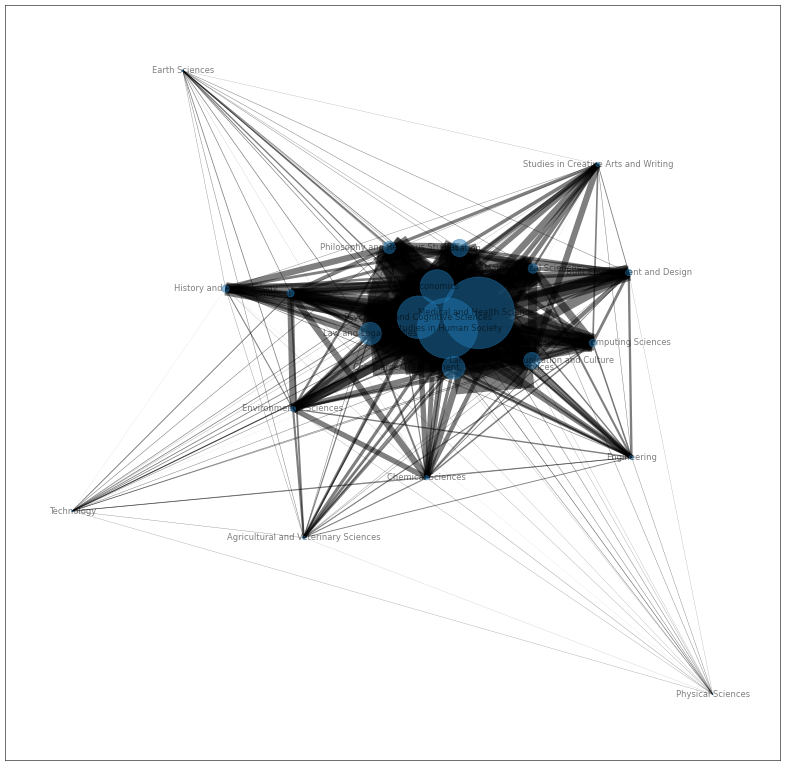

In [5]:
B = nx.Graph()

B.add_nodes_from(field_df['FLD'], bipartite="field")
B.add_nodes_from(field_df['STUDY'], bipartite="study")

B.add_edges_from([(row['FLD'], row['STUDY']) for idx, row in field_df.iterrows()])

print(nx.info(B))

nodeset = [n for n, d in B.nodes(data=True) if d["bipartite"] == 'field']
P = bipartite.weighted_projected_graph(B, nodeset)

sizes = dict(Counter(field_df.FLD))
nx.set_node_attributes(P, sizes, "node_size")

weights = nx.get_edge_attributes(P,'weight')
nx.set_edge_attributes(P, weights, "edge_weight")

print(nx.info(P))

#nx.write_gexf(P, "../outputs/FoS_level_1.gexf")

sizes = dict(Counter(field_df.FLD))
weights = [P[u][v]['weight'] for u,v in P.edges]

fig = plt.figure(1, figsize=(20, 20), dpi=50)
pos = nx.spring_layout(P)
plt.rcParams.update(plt.rcParamsDefault)
nx.draw_networkx(
    P,
    pos=pos,
    nodelist=sizes.keys(),
    node_size=[s*0.25 for s in sizes.values()],
    width=[w*0.1 for w in weights],
    alpha=0.5,
    with_labels=True)

weight_dict = nx.get_edge_attributes(P,'weight')

## Make Field of Research Subfield Network

In [6]:
B2 = nx.Graph()

B2.add_nodes_from(subfield_df['SUBFLD'], bipartite="field")
B2.add_nodes_from(subfield_df['STUDY'], bipartite="study")

B2.add_edges_from([(row['SUBFLD'], row['STUDY']) for idx, row in subfield_df.iterrows()])

print(nx.info(B2))

nodeset2 = [n for n, d in B2.nodes(data=True) if d["bipartite"] == 'field']
P2 = bipartite.weighted_projected_graph(B2, nodeset2)

sizes2 = dict(Counter(subfield_df.SUBFLD))

weight_dict2 = nx.get_edge_attributes(P2,'weight')
pos2 = nx.spring_layout(P2)

node_df2 = nodes2df(pos2,sizes2)
edge_df2,edge_info_df2 = edges2dfs(weight_dict2)

node_df2["Parent"] = node_df2.NodeName.apply(lambda x: subfield_field_dict[x])
node_df2
edge_df2
edge_info_df2

# Statistics 
def graph_metrics(G, weight=None):
    """Calculates metrics (density, transitivity, assortativity) and components for a graph.

    Parameters
    ----------
    G: networkx.classes.graph.Graph
        Graph
    weight: str or None
        Name of the edge attribute that holds edge weight
    Returns
    ------
    """
    
    density = nx.density(G)
    print("Network density:", density)
    transitivity = nx.transitivity(G)
    print("Network transitivity:", transitivity)
    assortativity = nx.degree_assortativity_coefficient(G, weight=weight)
    print("Network assortativity:", assortativity)
    print("Network is connected:", nx.is_connected(G))
    print("Network components:", nx.number_connected_components(G))

graph_metrics(P2)

Graph with 6154 nodes and 28419 edges
Network density: 0.514171511627907
Network transitivity: 0.7377813411078717
Network assortativity: -0.3009458379112537
Network is connected: True
Network components: 1


## Detect communities in Field of Research Network

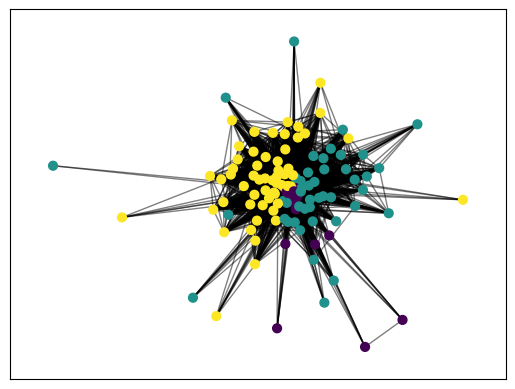

In [7]:
G = P2

#first compute the best partition
partition = community_louvain.best_partition(G)

# draw the graph
pos = nx.spring_layout(G)

# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))

nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

Export for visualization in Tableau

In [9]:
# node_df = nodes2df(pos,sizes)
# edge_df,edge_size_df = edges2dfs(weight_dict)

# node_df.to_csv("../outputs/for_nodes_df.csv",index=False)
# edge_df.to_csv("../outputs/for_edges_df.csv",index=False)
# edge_size_df.to_csv("../outputs/for_edges_info_df.csv",index=False)